In [121]:
import numpy as np 
import matplotlib.pyplot as plt 
from sparse_rf.algs import *
from sparse_rf.modules import make_X, make_A
from sparse_rf.util import *
import sparse_rf.util.fns as fns 
import sparse_rf.util.polynomials as poly
from functools import partial
import random
import gc
from sklearn.preprocessing import MinMaxScaler

import sys

In [122]:
def make_W(d, q, n=1, dist=normal):
    num_supports = comb(d, q)
    W = np.zeros((n*num_supports, d))
    inds = combinations(range(d), d-q)
    ds = set(range(d))
    inds_track = []
    for i in range(num_supports):
        ind = next(inds)
        inds_track.append(ds.difference(set(ind)))
        for j in range(n):
            w = dist(d)
            w[list(ind)] = 0
            W[i*n+j, :] = w
    return W, inds_track

In [123]:
data = np.loadtxt("airfoil_self_noise.dat")

ratio_train = 0.6
ratio_val = 0.2
ratio_test = 0.2

X = data[:, :-1]
y = data[:, -1]

m = len(y)

In [136]:
d = X.shape[-1]
q = 1
N = 10000
n = N//comb(d, q)
w_scale = 1/np.sqrt(q)
active = fourier

train_val_inds = np.arange(int(m*ratio_test), m)
train_inds = np.sort(np.random.choice(train_val_inds, int(m*ratio_train), replace=False))
val_inds = np.setdiff1d(train_val_inds, train_inds)

X_train = X[train_inds, :]
X_val = X[val_inds, :]
y_train = y[train_inds]
y_val = y[val_inds]

X_test = X[:int(m*ratio_test), :]
y_test = y[:int(m*ratio_test)]

np.linalg.norm(y_train)

3766.3096370469866

In [137]:
norm = MinMaxScaler().fit(X_train)
X_train = norm.transform(X_train)
X_val = norm.transform(X_val)
X_test = norm.transform(X_test)


In [138]:
W, inds = make_W(d, q, n=n, dist=partial(normal, stdev=w_scale))
A_train = make_A(X_train, W, active=active)
A_val = make_A(X_val, W, active=active)
A_test = make_A(X_test, W, active=active)
inds

[{4}, {3}, {2}, {1}, {0}]

In [139]:
c_l2 = min_l2(A_train, y_train)
np.linalg.norm(A_val@c_l2-y_val) / np.linalg.norm(y_val)

0.038718771569337763

In [140]:
A_val.shape

(302, 20000)

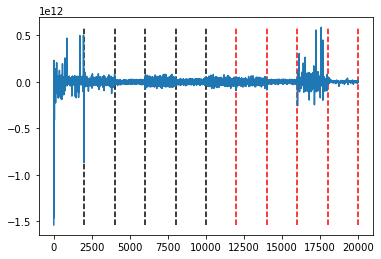

In [141]:
plt.plot(c_l2)
for i in range(len(inds)):
    plt.vlines((len(c_l2)//(2*len(inds)))*(i+1), min(c_l2), max(c_l2), color="black", linestyles="--")
for i in range(len(inds)):
    plt.vlines((len(c_l2)//(2*len(inds)))*(i+len(inds)+1), min(c_l2), max(c_l2), color="red", linestyles="--")

In [142]:
# c_l1 = min_l1(A_train, y_train, eta=0)
# np.linalg.norm(A_val@c_l1-y_val) / np.linalg.norm(y_val)

In [143]:
# plt.plot(c_l1)
# for i in range(len(inds)):
#     plt.vlines((len(c_l1)//(2*len(inds)))*(i+1), min(c_l1), max(c_l1), color="black", linestyles="--")
# for i in range(len(inds)):
#     plt.vlines((len(c_l1)//(2*len(inds)))*(i+len(inds)+1), min(c_l1), max(c_l1), color="red", linestyles="--")

In [144]:
# len(np.nonzero(c_l1)[0])

## TESTING

In [145]:
# np.linalg.norm(A_test@c_l1-y_test) / np.linalg.norm(y_test)

In [146]:
np.linalg.norm(A_test@c_l2-y_test) / np.linalg.norm(y_test)

99878889.64217311